# Attention Loss Distillation sudo code

In [ ]:
def distillation(train_loader, teacher, student, criterion, optimizer, epoch, reg=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    ce_losses = AverageMeter()
    dis_losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    student.train()
    if args.distype != 'OD':
        teacher.eval()
    else:
        teacher.train()
    loss = 0
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        target = target.cuda()

        # distilling
        if args.distype == 'AT':
            beta = 1e+3
            att_loss = 0
            t_output, t_middle_output = teacher(input, type=args.distype)
            s_output, s_middle_output = student(input, type=args.distype)
            for k in range(len(t_middle_output)):
                att_loss += attention_loss(t_middle_output[k].detach(), s_middle_output[k])
            ce_loss = criterion(s_output, target)
            loss = ce_loss + (beta / 2) * att_loss
            dis_loss = att_loss
        else:
            print("No Distillation")
            return

        # measure accuracy and record loss
        prec1, prec5 = accuracy(s_output.data, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))
        top5.update(prec5.item(), input.size(0))

        ce_losses.update(ce_loss.item(), input.size(0))
        dis_losses.update(dis_loss.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))

    return top1.avg, top5.avg, ce_losses, dis_losses


def attention(x):
    return F.normalize(x.pow(2).mean(1).view(x.size(0), -1))


def attention_loss(t, s):
    return (attention(t) - attention(s)).pow(2).mean()

mean()연산 이해

In [26]:
x = torch.rand(1, 3, 32, 32)
x.shape

torch.Size([1, 3, 32, 32])

In [38]:
x = torch.rand(3,3)
print(x)
print(x.mean(1))    # 열을 지워버림

tensor([[0.2243, 0.6665, 0.4135],
        [0.9514, 0.6456, 0.0485],
        [0.0310, 0.7587, 0.0381]])
tensor([0.4348, 0.5485, 0.2759])


Attention Maps Visualization
==========

Simple visualization of ResNet-34 attention maps

In [1]:
from PIL import Image
import requests
import numpy as np
from io import BytesIO
import torch
from torch import nn
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.transforms as T
import torch.nn.functional as F
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Will use basic ResNet-34 from torch model zoo:

In [2]:
base_resnet34 = resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [3]:
class ResNet34AT(ResNet):
    """Attention maps of ResNet-34.
    
    Overloaded ResNet model to return attention maps.
    """
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        g0 = self.layer1(x)
        g1 = self.layer2(g0)
        g2 = self.layer3(g1)
        g3 = self.layer4(g2)
        
        return [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]
    
model = ResNet34AT(BasicBlock, [3, 4, 6, 3])
model.load_state_dict(base_resnet34.state_dict())

<All keys matched successfully>

Load an image:

In [4]:
def load(url):
    response = requests.get(url)
    return np.ascontiguousarray(Image.open(BytesIO(response.content)), dtype=np.uint8)

im = load('http://www.zooclub.ru/attach/26000/26132.jpg')

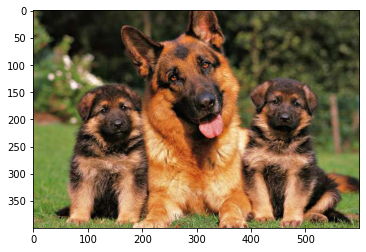

In [5]:
plt.imshow(im);

In [6]:
tr_center_crop = T.Compose([
        T.ToPILImage(),
        T.Resize(256),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Visualize attention maps for each group:

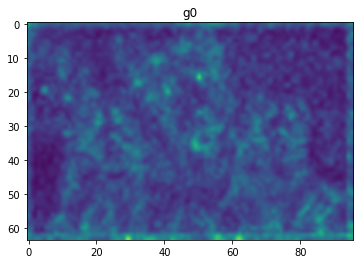

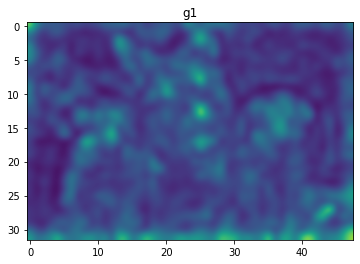

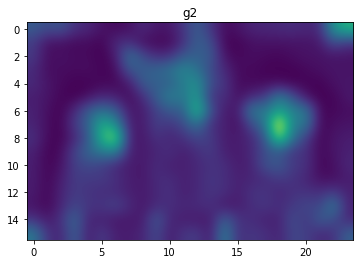

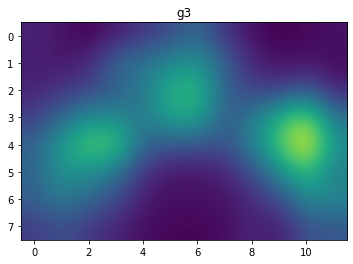

In [7]:
model.eval()
with torch.no_grad():
    x = tr_center_crop(im).unsqueeze(0)
    gs = model(x)

for i, g in enumerate(gs):
    plt.imshow(g[0], interpolation='bicubic')
    plt.title(f'g{i}')
    plt.show()